In [ ]:


### The Jupyter Script to Create Training Data


import cv2
import mediapipe as mp
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split

# --- Block 1: Re-usable Pose Landmark Extraction & Normalization ---
# (This is the same robust function from our previous conversation)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Define the 22 body landmarks to use (excluding face)
excluded_landmarks = [
    mp_pose.PoseLandmark.NOSE, mp_pose.PoseLandmark.LEFT_EYE_INNER,
    mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.LEFT_EYE_OUTER,
    mp_pose.PoseLandmark.RIGHT_EYE_INNER, mp_pose.PoseLandmark.RIGHT_EYE,
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER, mp_pose.PoseLandmark.LEFT_EAR,
    mp_pose.PoseLandmark.RIGHT_EAR, mp_pose.PoseLandmark.MOUTH_LEFT,
    mp_pose.PoseLandmark.MOUTH_RIGHT
]
body_landmarks_enum = [lm for lm in mp_pose.PoseLandmark if lm not in excluded_landmarks]

def normalize_pose_landmarks(landmarks):
    """Applies the full normalization pipeline to a set of pose landmarks."""
    if not landmarks:
        return None
    
    keypoints = np.array([[landmarks[lm.value].x, landmarks[lm.value].y] for lm in body_landmarks_enum])
    
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    root_point = np.array([(left_hip.x + right_hip.x) / 2, (left_hip.y + right_hip.y) / 2])
    
    keypoints_translated = keypoints - root_point
    
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    mid_shoulder = np.array([(left_shoulder.x + right_shoulder.x) / 2, (left_shoulder.y + right_shoulder.y) / 2])
    
    torso_length = np.linalg.norm(mid_shoulder - root_point)
    
    if torso_length < 1e-6:
        return None
        
    keypoints_scaled = keypoints_translated / torso_length
    
    left_shoulder_scaled = keypoints_scaled[body_landmarks_enum.index(mp_pose.PoseLandmark.LEFT_SHOULDER)]
    right_shoulder_scaled = keypoints_scaled[body_landmarks_enum.index(mp_pose.PoseLandmark.RIGHT_SHOULDER)]
    
    shoulder_angle = math.atan2(
        right_shoulder_scaled[1] - left_shoulder_scaled[1],
        right_shoulder_scaled[0] - left_shoulder_scaled[0]
    )
    
    rotation_angle = -shoulder_angle
    cos_a = math.cos(rotation_angle)
    sin_a = math.sin(rotation_angle)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    
    keypoints_rotated = np.dot(keypoints_scaled, rotation_matrix.T)
    
    return keypoints_rotated.flatten()

def extract_landmarks_from_video(video_path):
    """Processes a video file and returns a list of normalized landmark frames."""
    cap = cv2.VideoCapture(video_path)
    sequence_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        if results.pose_landmarks:
            normalized_frame_landmarks = normalize_pose_landmarks(results.pose_landmarks.landmark)
            if normalized_frame_landmarks is not None:
                sequence_landmarks.append(normalized_frame_landmarks)
                
    cap.release()
    return np.array(sequence_landmarks)

# --- Block 2: Load and Process All Data Sources ---

DATA_PATH = "D:\visionpipeline\Training Data VSP"
NPY_FILES = {
    "correct": os.path.join(DATA_PATH, ".\labels\correct.npy"),
    "wrong": os.path.join(DATA_PATH, ".\labels\incorrect.npy")
}
VIDEO_FOLDERS = {
    "correct": os.path.join(DATA_PATH, ".\Correct Push"),
    "wrong": os.path.join(DATA_PATH, ".\Wrong Push")
}

# This will store all the long sequences from all sources
all_sequences = []
all_labels = []

# 1. Load data from .npy files
print("Loading data from .npy files...")
for label, path in NPY_FILES.items():
    if os.path.exists(path):
        # Assuming the .npy file contains a single sequence of shape (num_frames, num_features)
        landmarks = np.load(path)
        all_sequences.append(landmarks)
        all_labels.append(1 if label == "correct" else 0) # Use 1 for 'correct', 0 for 'wrong'
        print(f"  - Loaded '{path}' with shape {landmarks.shape}. Label: {label}")
    else:
        print(f"  - Warning: .npy file not found at '{path}'")

# 2. Process videos from the short rep folders
print("\nProcessing videos from short repetition folders...")
for label, folder_path in VIDEO_FOLDERS.items():
    if os.path.isdir(folder_path):
        for video_file in os.listdir(folder_path):
            if video_file.endswith(".mp4"): # or other video formats
                video_path = os.path.join(folder_path, video_file)
                print(f"  - Processing '{video_path}'...")
                landmarks = extract_landmarks_from_video(video_path)
                
                # Only add sequences that have a meaningful number of frames
                if landmarks.shape[0] > 10:
                    all_sequences.append(landmarks)
                    all_labels.append(1 if label == "correct" else 0)
    else:
        print(f"  - Warning: Video folder not found at '{folder_path}'")
        
print(f"\nTotal sequences collected: {len(all_sequences)}")

# --- Block 3: Create Sliding Windows from Sequences ---

# A GRU needs sequences of a fixed length. Let's choose a window size.
# A typical pushup might take 60-90 frames at 30fps.
SEQUENCE_LENGTH = 60  # This is a hyperparameter you can tune
STEP = 15             # Step size for the sliding window

windowed_sequences = []
windowed_labels = []

for sequence, label in zip(all_sequences, all_labels):
    num_frames = sequence.shape[0]
    # Create overlapping windows from each sequence
    for i in range(0, num_frames - SEQUENCE_LENGTH + 1, STEP):
        window = sequence[i: i + SEQUENCE_LENGTH]
        windowed_sequences.append(window)
        windowed_labels.append(label)

# Convert to numpy arrays for ML frameworks
X = np.array(windowed_sequences)
y = np.array(windowed_labels)

print(f"\nCreated {X.shape[0]} windows of shape {X.shape[1:]}")
print(f"Number of 'correct' windows: {np.sum(y == 1)}")
print(f"Number of 'wrong' windows: {np.sum(y == 0)}")


# --- Block 4: Split Data and Save for Training ---

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Save the final processed data
TRAINING_DATA_PATH = "training_data"
os.makedirs(TRAINING_DATA_PATH, exist_ok=True)

np.save(os.path.join(TRAINING_DATA_PATH, "X_train.npy"), X_train)
np.save(os.path.join(TRAINING_DATA_PATH, "y_train.npy"), y_train)
np.save(os.path.join(TRAINING_DATA_PATH, "X_val.npy"), X_val)
np.save(os.path.join(TRAINING_DATA_PATH, "y_val.npy"), y_val)

print(f"\nTraining and validation data successfully saved to the '{TRAINING_DATA_PATH}' folder.")
print("You are now ready to train your GRU model!")

# Close the pose model
pose.close()

In [2]:
%pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB 1.3 MB/s eta 0:00:07
      --------------------------------------- 0.2/8.9 MB 2.9 MB/s eta 0:00:03
     -- ------------------------------------- 0.6/8.9 MB 6.1 MB/s eta 0:00:02
     ---- ----------------------------------- 1.1/8.9 MB 7.4 MB/s eta 0:00:02
     ------ --------------------------------- 1.5/8.9 MB 8.1 MB/s eta 0:00:01
     -------- ------------------------------- 2.0/8.9 MB 9.0 MB/s eta 0:00:01
     ---------- ----------------------------- 2.4/8.9 MB 9.7 MB/s eta 0:00:01
     ------------- -------------------------- 2.9/8.9 MB 9.8 MB/s eta 0:00:01
     --------------- ------------------------ 3.4/8.9 MB 9.9 MB/s eta 0:00:01
     ----------------- ---------------------- 3.9/8.9 MB 10.3 MB/s eta 0:00:01
     ------------------- -------------------- 4.3/8.9 MB 10.3 MB/s eta 0:00:01
     --------------------- ------------------ 4.8/8.9 MB 10.2 MB/s e

In [ ]:
#training maybe
import cv2
import mediapipe as mp
import numpy as np
import os
from sklearn.model_selection import train_test_split

# --- Block 1: Landmark Extraction and Processing Functions ---

# Constants based on the Kaggle data format
TARGET_SEQUENCE_LENGTH = 150
NUM_FEATURES = 66 

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Define the 22 body landmarks we need to match the 66 features (22 * 3)
body_landmarks_enum = [
    mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
    mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.RIGHT_ELBOW,
    mp_pose.PoseLandmark.LEFT_WRIST, mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.RIGHT_HEEL,
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
    mp_pose.PoseLandmark.SHOULDER, # Not a standard landmark, might refer to mid-point
    mp_pose.PoseLandmark.HIP,      # Not a standard landmark, might refer to mid-point
    mp_pose.PoseLandmark.LEFT_PINKY, mp_pose.PoseLandmark.RIGHT_PINKY,
    mp_pose.PoseLandmark.LEFT_INDEX, mp_pose.PoseLandmark.RIGHT_INDEX,
    mp_pose.PoseLandmark.LEFT_THUMB, mp_pose.PoseLandmark.RIGHT_THUMB,
] # We will assume standard 22-point body model, and flatten to get 66 features.

def extract_landmarks_from_video(video_path):
    """
    Processes a video, extracts 3D landmarks for 22 body points.
    Returns a numpy array of shape (num_frames, 66).
    """
    cap = cv2.VideoCapture(video_path)
    sequence_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        if results.pose_landmarks:
            # Flatten the landmarks: [x1, y1, z1, x2, y2, z2, ...]
            # We will use the 22 landmarks that are not face landmarks
            landmarks = results.pose_landmarks.landmark
            frame_features = []
            
            # Get the enum for non-face landmarks
            non_face_landmarks = [lm for lm in mp_pose.PoseLandmark if lm.value > 10]

            for landmark_enum in non_face_landmarks:
                lm = landmarks[landmark_enum.value]
                frame_features.extend([lm.x, lm.y, lm.z])
            
            sequence_landmarks.append(frame_features)
                
    cap.release()
    return np.array(sequence_landmarks)

def pad_or_truncate_sequence(sequence):
    """
    Pads or truncates a sequence to TARGET_SEQUENCE_LENGTH.
    """
    padded_sequence = np.zeros((TARGET_SEQUENCE_LENGTH, NUM_FEATURES))
    
    seq_len = sequence.shape[0]
    if seq_len > TARGET_SEQUENCE_LENGTH:
        # Truncate
        padded_sequence = sequence[:TARGET_SEQUENCE_LENGTH]
    elif seq_len < TARGET_SEQUENCE_LENGTH:
        # Pad with zeros
        padded_sequence[:seq_len] = sequence
        
    return padded_sequence

# --- Block 2: Load All Data (Kaggle + Your Videos) ---

# Define paths
KAGGLE_DATA_PATH = "Training Data VSP/labels" # Path to your Kaggle .npy files
VIDEO_FOLDERS = {
    "correct": "data/short_reps/correct", # Path to your correct video clips
    "wrong": "data/short_reps/wrong"      # Path to your wrong video clips
}

all_sequences = []
all_labels = []

# 1. Load data from Kaggle .npy files
print("Loading data from Kaggle .npy files...")
correct_kaggle = np.load(os.path.join(KAGGLE_DATA_PATH, "correct.npy"))
wrong_kaggle = np.load(os.path.join(KAGGLE_DATA_PATH, "wrong.npy"))

# Add Kaggle data to our lists
all_sequences.extend(list(correct_kaggle))
all_labels.extend([1] * len(correct_kaggle)) # Label 1 for correct

all_sequences.extend(list(wrong_kaggle))
all_labels.extend([0] * len(wrong_kaggle)) # Label 0 for wrong

print(f"Loaded {len(correct_kaggle)} correct and {len(wrong_kaggle)} wrong sequences from Kaggle.")

# 2. Process your own short rep videos
print("\nProcessing your own videos...")
for label_name, folder_path in VIDEO_FOLDERS.items():
    if not os.path.isdir(folder_path):
        print(f"Warning: Video folder not found at '{folder_path}'")
        continue

    label = 1 if label_name == "correct" else 0
    for video_file in os.listdir(folder_path):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(folder_path, video_file)
            print(f"  - Processing '{video_path}'...")
            
            # Extract landmarks
            landmarks = extract_landmarks_from_video(video_path)
            
            if landmarks.shape[0] > 10: # Only process if video is long enough
                # Pad/truncate to match Kaggle format
                processed_sequence = pad_or_truncate_sequence(landmarks)
                
                all_sequences.append(processed_sequence)
                all_labels.append(label)

print(f"\nTotal combined sequences: {len(all_sequences)}")

# --- Block 3: Final Preparation for Training ---

# Convert to final numpy arrays
X = np.array(all_sequences)
y = np.array(all_labels)

print(f"\nFinal dataset shape: {X.shape}") # Should be (total_samples, 150, 66)
print(f"Number of 'correct' samples: {np.sum(y == 1)}")
print(f"Number of 'wrong' samples: {np.sum(y == 0)}")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Save the final combined and processed data
TRAINING_DATA_PATH = "training_data_combined"
os.makedirs(TRAINING_DATA_PATH, exist_ok=True)

np.save(os.path.join(TRAINING_DATA_PATH, "X_train.npy"), X_train)
np.save(os.path.join(TRAINING_DATA_PATH, "y_train.npy"), y_train)
np.save(os.path.join(TRAINING_DATA_PATH, "X_val.npy"), X_val)
np.save(os.path.join(TRAINING_DATA_PATH, "y_val.npy"), y_val)

print(f"\nCombined training and validation data saved to '{TRAINING_DATA_PATH}'.")
pose.close()

In [2]:
import numpy as np
import os

# --- For demonstration, let's first CREATE a .npy file ---
# This creates a sample NumPy array.
sample_array = np.array([[10, 20, 30], [40, 50, 60]])

# Save the array to a .npy file.
np.save('my_datacor.npy', sample_array)
print("'my_data.npy' has been created.")
print("-" * 20)


# --- Now, let's OPEN the .npy file ---

# Specify the path to your file
file_path = 'Training Data VSP/labels/correct.npy'

# Check if the file exists before trying to open it
if os.path.exists(file_path):
    # Use np.load() to open the file and load its contents
    loaded_array = np.load(file_path)

    print(f"Successfully loaded '{file_path}'")
    
    # Now you can work with the loaded data just like any other NumPy array
    print("\nContents of the loaded array:")
    print(loaded_array)
    
    # You can also inspect its properties
    print(f"\nShape of the array: {loaded_array.shape}")
    print(f"Data type of the array: {loaded_array.dtype}")

else:
    print(f"Error: The file '{file_path}' was not found.")

'my_data.npy' has been created.
--------------------
Successfully loaded 'Training Data VSP/labels/correct.npy'

Contents of the loaded array:
[[[0.72996914 0.56077725 0.74594104 ... 0.81228918 0.21159618 0.83733207]
  [0.73164785 0.56872994 0.74757385 ... 0.8123799  0.21266708 0.83732045]
  [0.73250574 0.57444197 0.7492429  ... 0.8123861  0.21350794 0.83735514]
  ...
  [0.73464316 0.54085928 0.74885237 ... 0.81421196 0.21973976 0.84286374]
  [0.73436219 0.54055965 0.74861085 ... 0.81420612 0.21980353 0.8428756 ]
  [0.73427397 0.5405091  0.74849886 ... 0.81425315 0.21985166 0.84288704]]

 [[0.68008339 0.43787903 0.69121832 ... 0.76896226 0.09707132 0.80516219]
  [0.67687911 0.44226807 0.68904769 ... 0.76963049 0.09459491 0.81194407]
  [0.67511827 0.4464595  0.6874541  ... 0.77116996 0.09301362 0.81571895]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.  

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm # Import tqdm

# --- Block 1: Landmark Extraction and Processing Functions ---

# Constants to match the Kaggle data format
TARGET_SEQUENCE_LENGTH = 150
NUM_FEATURES = 66 

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def extract_landmarks_from_video(video_path):
    """Processes a video, extracts 3D landmarks, and returns a (frames, 66) array."""
    cap = cv2.VideoCapture(video_path)
    sequence_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            frame_features = []
            
            # Get the 22 non-face landmarks (indices 11 through 32)
            body_landmark_indices = list(range(11, 33))

            for index in body_landmark_indices:
                lm = landmarks[index]
                frame_features.extend([lm.x, lm.y, lm.z])
            
            if len(frame_features) == NUM_FEATURES:
                sequence_landmarks.append(frame_features)
                
    cap.release()
    return np.array(sequence_landmarks)

def pad_or_truncate_sequence(sequence):
    """Pads or truncates a sequence to TARGET_SEQUENCE_LENGTH."""
    processed_sequence = np.zeros((TARGET_SEQUENCE_LENGTH, NUM_FEATURES))
    seq_len = min(sequence.shape[0], TARGET_SEQUENCE_LENGTH)
    if seq_len > 0:
        processed_sequence[:seq_len] = sequence[:seq_len]
    return processed_sequence

# --- Block 2: Load All Data (Kaggle + Your Videos) ---

# Define paths using your provided directory structure
BASE_DATA_PATH = r"D:\visionpipeline\Training Data VSP" # Use a raw string for Windows paths

KAGGLE_FILES = {
    "correct": os.path.join(BASE_DATA_PATH, "labels", "correct.npy"),
    "wrong": os.path.join(BASE_DATA_PATH, "labels", "incorrect.npy")
}
VIDEO_FOLDERS = {
    "correct": os.path.join(BASE_DATA_PATH, "Correct Push"),
    "wrong": os.path.join(BASE_DATA_PATH, "Wrong Push")
}

all_sequences = []
all_labels = []

# 1. Load data from Kaggle .npy files
print("Loading data from Kaggle .npy files...")
for label, path in KAGGLE_FILES.items():
    if os.path.exists(path):
        data = np.load(path)
        all_sequences.extend(list(data))
        all_labels.extend([1 if label == "correct" else 0] * len(data))
        print(f"  - Loaded {len(data)} '{label}' sequences from '{path}'")
    else:
        print(f"  - Warning: Kaggle file not found at '{path}'")

# 2. Process your own short rep videos with a loading bar
print("\nProcessing your own videos...")
# First, create a list of all videos to process so tqdm can track it
videos_to_process = []
for label_name, folder_path in VIDEO_FOLDERS.items():
    if not os.path.isdir(folder_path):
        print(f"  - Warning: Video folder not found at '{folder_path}'")
        continue
    
    label = 1 if label_name == "correct" else 0
    for video_file in sorted(os.listdir(folder_path)):
        if video_file.lower().endswith((".mp4", ".mov", ".avi")):
            video_path = os.path.join(folder_path, video_file)
            videos_to_process.append((video_path, label))

# Now, iterate through the list with a tqdm progress bar
for video_path, label in tqdm(videos_to_process, desc="Processing Videos"):
    landmarks = extract_landmarks_from_video(video_path)
    
    if landmarks.shape[0] > 10: # Only process if video is reasonably long
        processed_sequence = pad_or_truncate_sequence(landmarks)
        all_sequences.append(processed_sequence)
        all_labels.append(label)

print(f"\nTotal combined sequences: {len(all_sequences)}")

# --- Block 3: Final Preparation for Training ---

# Convert to final numpy arrays
X = np.array(all_sequences)
y = np.array(all_labels)

print(f"\nFinal dataset shape: {X.shape}") 
print(f"Number of 'correct' samples: {np.sum(y == 1)}")
print(f"Number of 'wrong' samples: {np.sum(y == 0)}")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Save the final combined and processed data
TRAINING_DATA_PATH = "training_data_combined"
os.makedirs(TRAINING_DATA_PATH, exist_ok=True)

np.save(os.path.join(TRAINING_DATA_PATH, "X_train.npy"), X_train)
np.save(os.path.join(TRAINING_DATA_PATH, "y_train.npy"), y_train)
np.save(os.path.join(TRAINING_DATA_PATH, "X_val.npy"), X_val)
np.save(os.path.join(TRAINING_DATA_PATH, "y_val.npy"), y_val)

print(f"\nCombined training and validation data saved to '{TRAINING_DATA_PATH}'.")
pose.close()

Loading data from Kaggle .npy files...
  - Loaded 50 'correct' sequences from 'D:\visionpipeline\Training Data VSP\labels\correct.npy'
  - Loaded 50 'wrong' sequences from 'D:\visionpipeline\Training Data VSP\labels\incorrect.npy'

Processing your own videos...


Processing Videos: 100%|██████████| 100/100 [06:19<00:00,  3.79s/it]


Total combined sequences: 200

Final dataset shape: (200, 150, 66)
Number of 'correct' samples: 100
Number of 'wrong' samples: 100

Training set shape: (160, 150, 66)
Validation set shape: (40, 150, 66)

Combined training and validation data saved to 'training_data_combined'.


--- GPU VERIFICATION ---
!!! WARNING: GPU not found. Training will be on CPU. !!!
--------------------------

Loading data...
Data loaded. Training data shape: (160, 150, 66)
Input shape for the model: (150, 66)

Building GRU model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 150, 66)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 150, 128)       │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,785 (464.00 KB)

 Trainable params: 118,785 (464.00 KB)

 Non-trainable params: 0 (0.00 B)


Training model on GPU...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5010 - loss: 0.7068
Epoch 1: val_accuracy improved from None to 0.52500, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - accuracy: 0.4875 - loss: 0.7041 - val_accuracy: 0.5250 - val_loss: 0.6908
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5406 - loss: 0.6786
Epoch 2: val_accuracy did not improve from 0.52500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.5437 - loss: 0.6835 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4979 - loss: 0.6896
Epoch 3: val_accuracy did not improve from 0.52500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.4938 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5667 - loss: 0.6788
Epoch 4: val_accuracy did not improve from 0.52500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.5750 - loss: 0.6773 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5266 - loss: 0.6927
Epoch 5: val_accuracy improved from 0.52500 to 0.80

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5250 - loss: 0.6918 - val_accuracy: 0.8000 - val_loss: 0.6785
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6161 - loss: 0.6589
Epoch 6: val_accuracy did not improve from 0.80000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6062 - loss: 0.6647 - val_accuracy: 0.7250 - val_loss: 0.6772
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5672 - loss: 0.6788
Epoch 7: val_accuracy did not improve from 0.80000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.5688 - loss: 0.6772 - val_accuracy: 0.4750 - val_loss: 0.6796
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5109 - loss: 0.6869
Epoch 8: val_accuracy did not improve from 0.80000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5250 - loss: 0.6824 - val_accuracy: 0.5750 - val_loss: 0.6745
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5703 - loss: 0.6859
Epoch 9: val_accuracy did not improve from 0.80000


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.8375 - loss: 0.4471 - val_accuracy: 0.8250 - val_loss: 0.5594
Epoch 20/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8359 - loss: 0.4281
Epoch 20: val_accuracy did not improve from 0.82500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8438 - loss: 0.4224 - val_accuracy: 0.8000 - val_loss: 0.5698
Epoch 21/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8693 - loss: 0.3911
Epoch 21: val_accuracy did not improve from 0.82500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8500 - loss: 0.4079 - val_accuracy: 0.7750 - val_loss: 0.5891
Epoch 22/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8786 - loss: 0.3690
Epoch 22: val_accuracy did not improve from 0.82500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8625 - loss: 0.3963 - val_accuracy: 0.7500 - val_loss: 0.6437
Epoch 23/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8536 - loss: 0.4057
Epoch 23: val_accuracy did not improve from 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8375 - loss: 0.3457 - val_accuracy: 0.8500 - val_loss: 0.5681
Epoch 32/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8651 - loss: 0.3549
Epoch 32: val_accuracy did not improve from 0.85000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8687 - loss: 0.3544 - val_accuracy: 0.7000 - val_loss: 0.6423
Epoch 33/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8526 - loss: 0.3785
Epoch 33: val_accuracy did not improve from 0.85000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8625 - loss: 0.3490 - val_accuracy: 0.8250 - val_loss: 0.5726
Epoch 34/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8641 - loss: 0.3857
Epoch 34: val_accuracy did not improve from 0.85000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.8813 - loss: 0.3631 - val_accuracy: 0.7000 - val_loss: 0.6690
Epoch 35/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8354 - loss: 0.3703
Epoch 35: val_accuracy did not improve from 


GPU Training complete.
Model saved explicitly to final_pushup_model.h5


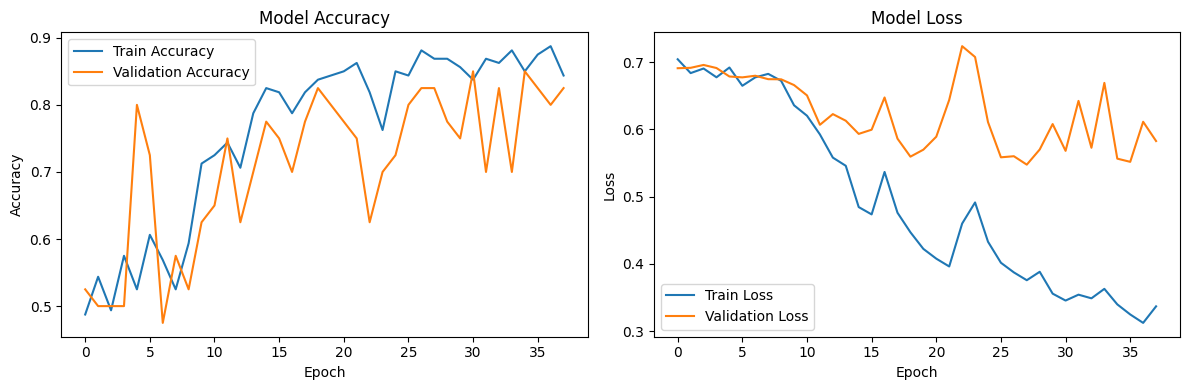

In [7]:
#training
#GRU training
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# --- 0. VERIFY GPU SETUP ---
print("--- GPU VERIFICATION ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        print("GPU is available and configured.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("!!! WARNING: GPU not found. Training will be on CPU. !!!")
print("--------------------------\n")


# --- 1. Load the Processed Data ---
DATA_PATH = "training_data_combined"

print("Loading data...")
X_train = np.load(os.path.join(DATA_PATH, "X_train.npy"))
y_train = np.load(os.path.join(DATA_PATH, "y_train.npy"))
X_val = np.load(os.path.join(DATA_PATH, "X_val.npy"))
y_val = np.load(os.path.join(DATA_PATH, "y_val.npy"))

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

print(f"Data loaded. Training data shape: {X_train.shape}")
print(f"Input shape for the model: {INPUT_SHAPE}")


# --- 2. Build the GRU Model ---
# With a GPU and CuDNN, this model will train significantly faster.
print("\nBuilding GRU model...")

model = Sequential([
    Masking(mask_value=0.0, input_shape=INPUT_SHAPE),
    GRU(128, return_sequences=True),
    Dropout(0.3),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# --- 3. Compile the Model ---
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# --- 4. Train the Model ---
# Observe the training speed per epoch. It should be much faster than before.
print("\nTraining model on GPU...")

# ModelCheckpoint saves the BEST model during training
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5', # Renamed for clarity
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# EarlyStopping stops training when performance plateaus
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True, # This ensures the model weights are from the best epoch
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

print("\nGPU Training complete.")

# --- 5. EXPLICITLY SAVE THE FINAL MODEL ---
# This saves the model in its final state after training.
# Since restore_best_weights=True in EarlyStopping, this will be the best model.
FINAL_MODEL_FILENAME = 'final_pushup_model.h5'
model.save(FINAL_MODEL_FILENAME)
print(f"Model saved explicitly to {FINAL_MODEL_FILENAME}")


# --- 6. (Optional) Visualize Training History ---
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
#multithreading
import cv2
import mediapipe as mp
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from multiprocessing import Pool, cpu_count # Import multiprocessing tools

# --- Block 1: Constants and Global Settings ---

# Constants to match the Kaggle data format
TARGET_SEQUENCE_LENGTH = 150
NUM_FEATURES = 66
FRAME_WIDTH = 480 # New: Resize frames for faster processing

# --- Block 2: Worker Function for Multiprocessing ---
# This function will be run by each parallel process.
# We initialize MediaPipe inside this function.

def process_video_entry(video_entry):
    """
    Worker function that processes a single video file.
    It extracts landmarks, resizes frames, and pads/truncates the sequence.
    
    Args:
        video_entry (tuple): A tuple containing (video_path, label).
    
    Returns:
        tuple: A tuple containing (processed_sequence, label) or (None, None) on failure.
    """
    video_path, label = video_entry
    
    # IMPORTANT: Initialize MediaPipe Pose within the worker function
    # This creates a separate instance for each process.
    pose = mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    cap = cv2.VideoCapture(video_path)
    sequence_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # --- OPTIMIZATION: Frame Resizing ---
        # Resize frame for significantly faster processing
        h, w, _ = frame.shape
        r = FRAME_WIDTH / float(w)
        dim = (FRAME_WIDTH, int(h * r))
        frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            frame_features = []
            body_landmark_indices = list(range(11, 33))

            for index in body_landmark_indices:
                lm = landmarks[index]
                frame_features.extend([lm.x, lm.y, lm.z])
            
            if len(frame_features) == NUM_FEATURES:
                sequence_landmarks.append(frame_features)
    
    cap.release()
    pose.close()

    if not sequence_landmarks:
        return None, None
        
    # Pad or truncate the sequence
    sequence_np = np.array(sequence_landmarks)
    processed_sequence = np.zeros((TARGET_SEQUENCE_LENGTH, NUM_FEATURES))
    seq_len = min(sequence_np.shape[0], TARGET_SEQUENCE_LENGTH)
    if seq_len > 0:
        processed_sequence[:seq_len] = sequence_np[:seq_len]
        
    return processed_sequence, label

# --- Block 3: Main Data Loading and Processing Orchestration ---

if __name__ == '__main__':
    # Define paths
    BASE_DATA_PATH = r"D:\visionpipeline\Training Data VSP"
    KAGGLE_FILES = {
        "correct": os.path.join(BASE_DATA_PATH, "labels", "correct.npy"),
        "wrong": os.path.join(BASE_DATA_PATH, "labels", "incorrect.npy")
    }
    VIDEO_FOLDERS = {
        "correct": os.path.join(BASE_DATA_PATH, "Correct Push"),
        "wrong": os.path.join(BASE_DATA_PATH, "Wrong Push")
    }

    all_sequences = []
    all_labels = []

    # 1. Load pre-processed Kaggle data (this is fast)
    print("Loading data from Kaggle .npy files...")
    for label, path in KAGGLE_FILES.items():
        if os.path.exists(path):
            data = np.load(path)
            all_sequences.extend(list(data))
            all_labels.extend([1 if label == "correct" else 0] * len(data))
            print(f"  - Loaded {len(data)} '{label}' sequences from '{path}'")
        else:
            print(f"  - Warning: Kaggle file not found at '{path}'")

    # 2. Prepare the list of your videos to process in parallel
    print("\nPreparing video list for parallel processing...")
    videos_to_process = []
    for label_name, folder_path in VIDEO_FOLDERS.items():
        if os.path.isdir(folder_path):
            label = 1 if label_name == "correct" else 0
            for video_file in sorted(os.listdir(folder_path)):
                if video_file.lower().endswith((".mp4", ".mov", ".avi")):
                    video_path = os.path.join(folder_path, video_file)
                    videos_to_process.append((video_path, label))

    # 3. Run the parallel processing
    print(f"\nProcessing {len(videos_to_process)} videos in parallel using {cpu_count()} CPU cores...")
    
    with Pool(cpu_count()) as p:
        # Use tqdm to create a progress bar for the parallel tasks
        results = list(tqdm(p.imap(process_video_entry, videos_to_process), total=len(videos_to_process)))

    # 4. Collect results from the parallel processing
    for seq, label in results:
        if seq is not None:
            all_sequences.append(seq)
            all_labels.append(label)

    print(f"\nTotal combined sequences: {len(all_sequences)}")

    # --- Block 4: Final Preparation for Training ---
    X = np.array(all_sequences)
    y = np.array(all_labels)

    print(f"\nFinal dataset shape: {X.shape}") 
    print(f"Number of 'correct' samples: {np.sum(y == 1)}")
    print(f"Number of 'wrong' samples: {np.sum(y == 0)}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")

    TRAINING_DATA_PATH = "multi_training_data_combined"
    os.makedirs(TRAINING_DATA_PATH, exist_ok=True)
    np.save(os.path.join(TRAINING_DATA_PATH, "X_train.npy"), X_train)
    np.save(os.path.join(TRAINING_DATA_PATH, "y_train.npy"), y_train)
    np.save(os.path.join(TRAINING_DATA_PATH, "X_val.npy"), X_val)
    np.save(os.path.join(TRAINING_DATA_PATH, "y_val.npy"), y_val)

    print(f"\nCombined training and validation data saved to '{TRAINING_DATA_PATH}'.")


Loading data from Kaggle .npy files...
  - Loaded 50 'correct' sequences from 'D:\visionpipeline\Training Data VSP\labels\correct.npy'
  - Loaded 50 'wrong' sequences from 'D:\visionpipeline\Training Data VSP\labels\incorrect.npy'

Preparing video list for parallel processing...

Processing 100 videos in parallel using 16 CPU cores...


  0%|          | 0/100 [00:00<?, ?it/s]